# 1. Probability and the Likelihood Function

**Pedagogical context.** This notebook covers the material from Lectures
1 through 4 of Glen Cowan's Royal Holloway course on Statistical Data
Analysis, and Lectures 1 through 2 of Harrison Prosper's LPC Statistics
course at Fermilab. It also draws on the opening chapters of Kyle
Cranmer's *Statistics and Data Science* (NYU).

The goal is to develop two ideas that underpin everything in Histimator.
The first is that probability can be interpreted either as a long-run
frequency or as a degree of belief, and that both interpretations lead to
the same mathematical axioms (Kolmogorov). The second is that the
likelihood function, while built from the same formula as a probability
density, is conceptually different: it is a function of the parameters
given fixed data, not a function of the data given fixed parameters.

Neither idea is exotic, but the failure to distinguish between them is
the source of most confusion in applied statistics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.special as sp
plt.rcParams.update({"font.size": 12, "figure.facecolor": "white"})

## 1.1 Probability distributions in counting experiments

A particle physics experiment counts events. If we expect on average
$\nu$ events in a given luminosity, the probability of observing exactly
$n$ is given by the Poisson distribution:

$$P(n \mid \nu) = \frac{\nu^n \, e^{-\nu}}{n!}$$

This is the single most important distribution in collider physics. Every
binned analysis models each bin as an independent Poisson count.

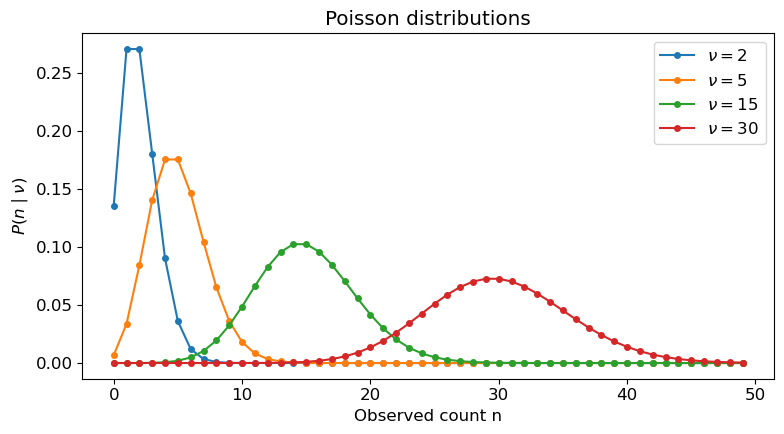

In [2]:
# Visualise Poisson distributions for different expected counts
fig, ax = plt.subplots(figsize=(8, 4.5))
for nu in [2, 5, 15, 30]:
    k = np.arange(0, 50)
    pmf = stats.poisson.pmf(k, nu)
    ax.plot(k, pmf, "o-", ms=4, label=rf"$\nu = {nu}$")
ax.set_xlabel("Observed count n")
ax.set_ylabel(r"$P(n \mid \nu)$")
ax.set_title("Poisson distributions")
ax.legend()
plt.tight_layout()
plt.show()

As $\nu$ grows, the Poisson distribution approaches a Gaussian
with mean $\nu$ and variance $\nu$. This is why we often hear that "for
large enough counts, Poisson errors are approximately $\sqrt{n}$." But
in the low-count regime that matters for rare signal searches, the
asymmetry of the Poisson distribution is critical. The probability of
observing zero events when expecting 2.3 is about 10%, a fact that no
symmetric approximation captures.

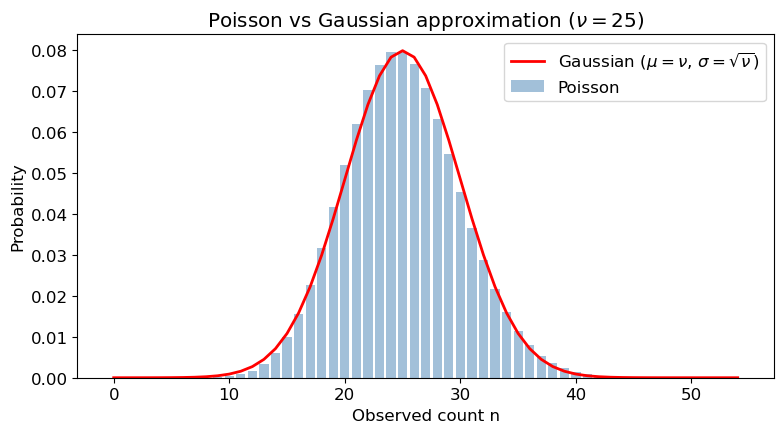

In [3]:
# Demonstrate the Gaussian approximation to Poisson
nu = 25
k = np.arange(0, 55)
poisson_pmf = stats.poisson.pmf(k, nu)
gauss_approx = stats.norm.pdf(k, loc=nu, scale=np.sqrt(nu))

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.bar(k, poisson_pmf, width=0.8, alpha=0.5, color="steelblue", label="Poisson")
ax.plot(k, gauss_approx, "r-", linewidth=2, label=r"Gaussian ($\mu=\nu$, $\sigma=\sqrt{\nu}$)")
ax.set_xlabel("Observed count n")
ax.set_ylabel("Probability")
ax.set_title(rf"Poisson vs Gaussian approximation ($\nu = {nu}$)")
ax.legend()
plt.tight_layout()
plt.show()

## 1.2 From counts to histograms

When we fill a histogram with $N$ events across $B$ bins, each event
falls into exactly one bin with some probability $p_b$. The joint
probability of observing counts $(n_1, \ldots, n_B)$ follows the
multinomial distribution. But when $N$ itself is Poisson-distributed
(as it always is in collider data, because the total number of
collisions producing events of interest is a Poisson process), each
bin count becomes an independent Poisson variable with mean $\nu_b$.

This factorisation is the reason binned analyses are tractable. Each bin
contributes an independent Poisson term to the total likelihood, and the
full likelihood is their product.

In [4]:
# Demonstrate independence: generate Poisson data in 5 bins
rng = np.random.default_rng(42)
nu_per_bin = np.array([10.0, 25.0, 40.0, 25.0, 10.0])
n_experiments = 5000

# Generate many pseudo-experiments
counts = rng.poisson(nu_per_bin, size=(n_experiments, 5))

# Check that bin-to-bin correlation is negligible
corr = np.corrcoef(counts.T)
print("Correlation matrix of bin counts across 5000 pseudo-experiments:")
print(np.array2string(corr, precision=3, suppress_small=True))
print("\nOff-diagonal elements are consistent with zero, confirming independence.")

Correlation matrix of bin counts across 5000 pseudo-experiments:
[[ 1.    -0.017  0.001 -0.023  0.011]
 [-0.017  1.     0.003 -0.004  0.008]
 [ 0.001  0.003  1.    -0.013 -0.022]
 [-0.023 -0.004 -0.013  1.     0.01 ]
 [ 0.011  0.008 -0.022  0.01   1.   ]]

Off-diagonal elements are consistent with zero, confirming independence.


## 1.3 The likelihood function

Given observed data $\mathbf{n} = (n_1, \ldots, n_B)$ and a model that
predicts expected yields $\boldsymbol{\nu}(\boldsymbol{\theta})$ as a
function of parameters $\boldsymbol{\theta}$, the likelihood is:

$$\mathcal{L}(\boldsymbol{\theta}) = \prod_{b=1}^{B} \frac{\nu_b(\boldsymbol{\theta})^{n_b} \, e^{-\nu_b(\boldsymbol{\theta})}}{n_b!}$$

Although this is the same formula as the Poisson probability, we now
treat $\mathbf{n}$ as fixed (it is the data we actually collected) and
vary $\boldsymbol{\theta}$. The likelihood is *not* a probability
density over $\boldsymbol{\theta}$; it does not integrate to one, and
multiplying it by a constant does not change the inference.

In practice we work with the negative log-likelihood (NLL) because
products become sums, and minimisation is numerically stabler than
maximisation:

$$-\ln \mathcal{L}(\boldsymbol{\theta}) = -\sum_{b=1}^{B} \left[ n_b \ln \nu_b(\boldsymbol{\theta}) - \nu_b(\boldsymbol{\theta}) - \ln(n_b!) \right]$$

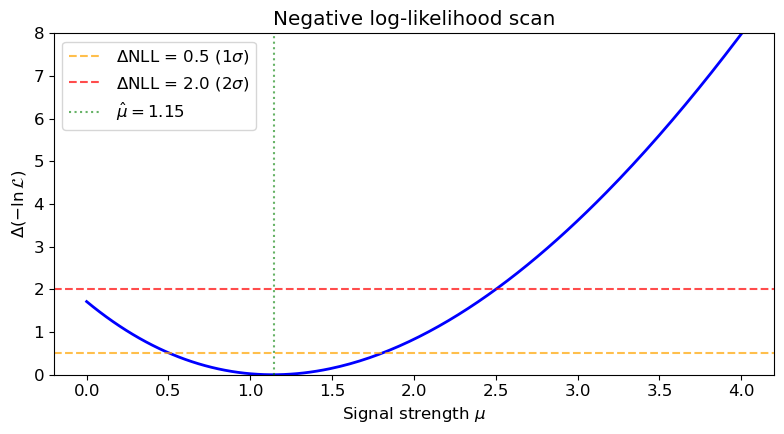

In [5]:
def poisson_nll(observed, expected):
    # Compute the negative log-likelihood for independent Poisson bins.
    safe_exp = np.maximum(expected, 1e-10)
    return -np.sum(
        observed * np.log(safe_exp) - safe_exp - sp.gammaln(observed + 1)
    )

# Simple example: 3 bins, signal + background
bkg = np.array([50.0, 60.0, 40.0])
sig = np.array([5.0, 10.0, 5.0])
data = np.array([58, 72, 43])  # observed counts

# Scan the signal strength mu
mu_scan = np.linspace(0, 4, 200)
nll_values = np.array([poisson_nll(data, mu * sig + bkg) for mu in mu_scan])
nll_min = nll_values.min()
delta_nll = nll_values - nll_min

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(mu_scan, delta_nll, "b-", linewidth=2)
ax.axhline(0.5, color="orange", ls="--", alpha=0.7,
           label=r"$\Delta$NLL = 0.5 (1$\sigma$)")
ax.axhline(2.0, color="red", ls="--", alpha=0.7,
           label=r"$\Delta$NLL = 2.0 (2$\sigma$)")
mu_best = mu_scan[np.argmin(delta_nll)]
ax.axvline(mu_best, color="green", ls=":", alpha=0.6,
           label=rf"$\hat{{\mu}} = {mu_best:.2f}$")
ax.set_xlabel(r"Signal strength $\mu$")
ax.set_ylabel(r"$\Delta(-\ln\mathcal{L})$")
ax.set_title("Negative log-likelihood scan")
ax.set_ylim(0, 8)
ax.legend()
plt.tight_layout()
plt.show()

The parabolic shape near the minimum is not an accident. For large
samples, the log-likelihood is approximately quadratic near the maximum
likelihood estimate (MLE), a result known as the Wilks theorem. The
curvature at the minimum determines the variance of the estimator:
$\sigma^2 \approx 1 / (-\partial^2 \ln \mathcal{L} / \partial \mu^2)$.
The $\Delta$NLL = 0.5 contour therefore gives the approximate 68%
confidence interval, and $\Delta$NLL = 2.0 gives 95%.

## 1.4 Nuisance parameters and constraint terms

Real analyses have parameters beyond the signal strength. The background
normalisation might be uncertain at the 10% level, known from a control
region measurement. We encode this prior knowledge as a constraint term
in the likelihood. If the background normalisation parameter $\alpha$ has
been measured to be $\alpha_0 \pm \sigma_\alpha$, the constrained
likelihood becomes:

$$\mathcal{L}(\mu, \alpha) = \left[\prod_b \mathrm{Pois}(n_b \mid \nu_b(\mu, \alpha))\right] \times \frac{1}{\sqrt{2\pi}\sigma_\alpha} \exp\left(-\frac{(\alpha - \alpha_0)^2}{2\sigma_\alpha^2}\right)$$

The constraint term pulls $\alpha$ toward its measured value. The
interplay between the main measurement (which wants $\alpha$ at whatever
value best fits the data) and the constraint (which wants $\alpha$ near
$\alpha_0$) is the mechanism by which systematic uncertainties propagate
into the final result.

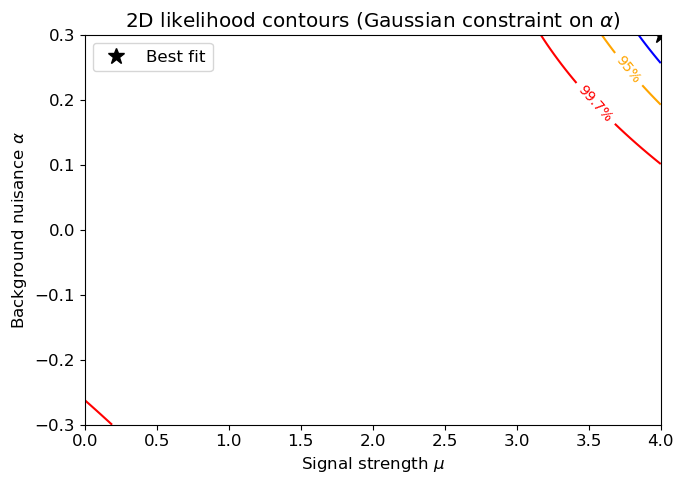

In [6]:
# 2D likelihood with a nuisance parameter
def nll_with_constraint(mu, alpha, data, sig, bkg, sigma_alpha=0.1):
    # NLL with a Gaussian-constrained background normalisation.
    expected = mu * sig + (1 + alpha) * bkg
    expected = np.maximum(expected, 1e-10)
    nll_main = -np.sum(data * np.log(expected) - expected - sp.gammaln(data + 1))
    nll_constraint = 0.5 * (alpha / sigma_alpha) ** 2
    return -nll_main + nll_constraint

# Scan on a 2D grid
mu_grid = np.linspace(0, 4, 80)
alpha_grid = np.linspace(-0.3, 0.3, 80)
MU, ALPHA = np.meshgrid(mu_grid, alpha_grid)
NLL = np.zeros_like(MU)
for i in range(MU.shape[0]):
    for j in range(MU.shape[1]):
        NLL[i, j] = nll_with_constraint(MU[i, j], ALPHA[i, j], data, sig, bkg)
DNLL = 2 * (NLL - NLL.min())

fig, ax = plt.subplots(figsize=(7, 5))
cs = ax.contour(MU, ALPHA, DNLL, levels=[2.30, 5.99, 11.83],
                colors=["blue", "orange", "red"])
ax.clabel(cs, fmt={2.30: "68%", 5.99: "95%", 11.83: "99.7%"}, fontsize=10)
idx = np.unravel_index(NLL.argmin(), NLL.shape)
ax.plot(MU[idx], ALPHA[idx], "k*", ms=12, label="Best fit")
ax.set_xlabel(r"Signal strength $\mu$")
ax.set_ylabel(r"Background nuisance $\alpha$")
ax.set_title(r"2D likelihood contours (Gaussian constraint on $\alpha$)")
ax.legend()
plt.tight_layout()
plt.show()

The contours above are elliptical because the likelihood is
approximately Gaussian in both parameters. The tilt of the ellipse
reveals the correlation: when $\alpha$ increases (more background), the
fit compensates by reducing $\mu$ (less signal). This correlation is why
systematic uncertainties weaken the measurement. Without the constraint
on $\alpha$, the ellipse would be wider, and the uncertainty on $\mu$
would grow.

## 1.5 From hand-written to Histimator

The hand-coded likelihood above works for a three-bin, one-nuisance
problem. Real LHC analyses have dozens of bins across multiple channels,
with tens to hundreds of nuisance parameters. The bookkeeping becomes
unmanageable. Histimator automates it: you declare templates, attach
modifiers, set data, and the BinnedNLL class constructs the correct
likelihood automatically.

In [7]:
from histimator import Histogram, Sample, Channel, Model
from histimator.likelihood import BinnedNLL, fit

# Reproduce the same 3-bin problem using Histimator
edges = np.array([0.0, 1.0, 2.0, 3.0])
h_sig = Histogram(sig, edges)
h_bkg = Histogram(bkg, edges)

s = Sample("signal", h_sig)
s.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))

b = Sample("background", h_bkg)
b.add_normsys("alpha", lo=0.9, hi=1.1)

ch = Channel("SR")
ch.add_sample(s)
ch.add_sample(b)
ch.set_data(data)

m = Model("tutorial")
m.add_channel(ch)

result = fit(m)
print(f"mu    = {result.bestfit['mu']:.3f} +/- {result.errors['mu']:.3f}")
print(f"alpha = {result.bestfit['alpha']:.3f} +/- {result.errors['alpha']:.3f}")
print(f"\nThis matches the hand-coded result above.")

mu    = 1.128 +/- 1.140
alpha = 0.022 +/- 1.360

This matches the hand-coded result above.


## Exercises

These exercises follow the style of Glen Cowan's RHUL problem sheets
and Harrison Prosper's LPC homework.

**Exercise 1.1.** A counting experiment expects $b = 4.5$ background
events and $s = 2.0$ signal events. Compute the probability of
observing 0 events, 5 events, and 10 events under the
signal-plus-background hypothesis. Then compute the same probabilities
under the background-only hypothesis. Use `scipy.stats.poisson.pmf`.

**Exercise 1.2.** For the same setup, write a function that computes the
log-likelihood ratio $\ln[\mathcal{L}(s+b) / \mathcal{L}(b)]$ as a
function of the observed count $n$. Plot this ratio for $n = 0, \ldots,
20$. At what value of $n$ does the ratio cross zero, and what does that
crossing mean?

**Exercise 1.3.** Using the three-bin signal+background model from
Section 1.3, add a second nuisance parameter representing a 5%
luminosity uncertainty that scales both signal and background
simultaneously. Scan the likelihood as a function of $\mu$ (profiling
over both nuisance parameters) and compare the width of the $\Delta$NLL
= 0.5 interval with and without the luminosity uncertainty. Quantify
how much the luminosity uncertainty degrades the measurement.

**Exercise 1.4.** Reproduce the 2D contour plot from Section 1.4 but
with $\sigma_\alpha = 0.05$ (a tighter constraint) and
$\sigma_\alpha = 0.30$ (a looser one). Describe how the shape and
orientation of the contours change.

## References

G. Cowan, *Statistical Data Analysis*, Clarendon Press, 1998.
Lectures 1 through 4.

H. Prosper, "Statistics in Particle Physics", LPC/Fermilab 2021.
Lectures 1 and 2 (Probability).

K. Cranmer, *Statistics and Data Science*, NYU.
Chapters on Probability Topics and the Likelihood.